In [1]:
# import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load the dataset
data = pd.read_csv('/kaggle/input/maternal-health-risk-data/Maternal Health Risk Data Set.csv')

# check the dimension of the data
print(data.shape)

# return the first 5 rows of the data
data.head()

(1014, 7)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


#### Attributes Description:

1. Age - Age in years when a woman is pregnant
2. SystolicBP - Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy
3. DiastolicBP - Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy
4. BS - Blood glucose levels is in terms of a molar concentration, mmol/L
5. BodyTemp - Body temperature in Fahrenheit
6. HeartRate - Resting heart rate in beats per minute
7. RiskLevel - Predicted Risk Intensity Level during pregnancy ['high risk', 'mid risk', 'low risk']

In [3]:
# high level overview of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [4]:
# convert the column `BodyTemp` to celcius unit
data['BodyTemp'] = data['BodyTemp'].apply(lambda x: round((x-32) * (5/9), 2))

### Data Preparation for Classification

In [5]:
# perform train test split
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=122)

# check the dimension of the train and test dataset after splitting
print('Training dataset: ', train.shape)
print('Test dataset: ', test.shape)

Training dataset:  (811, 7)
Test dataset:  (203, 7)


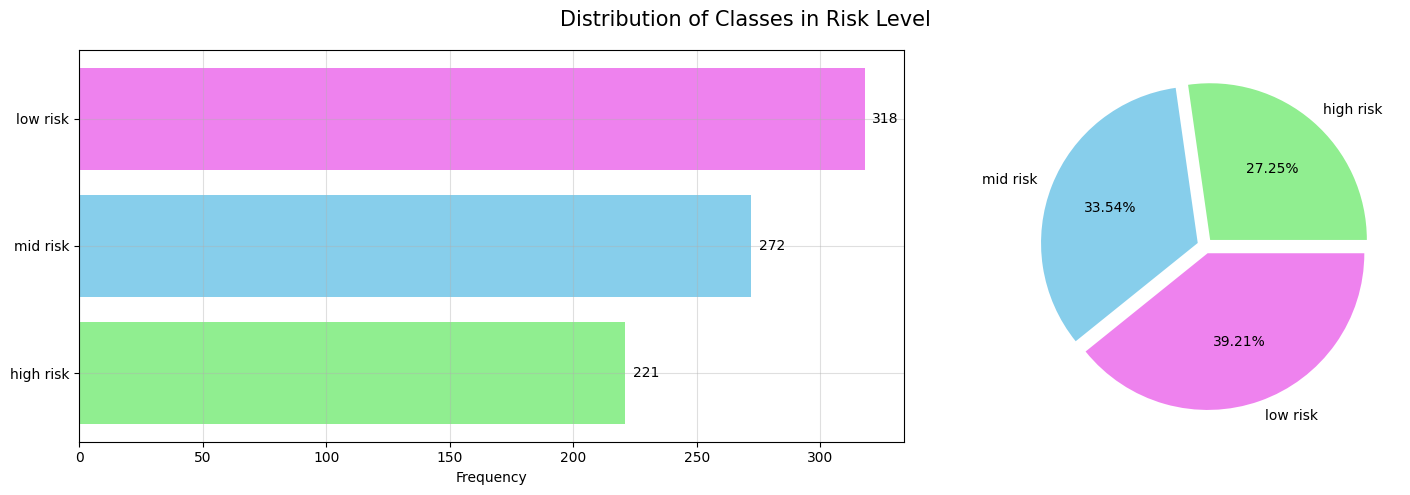

In [6]:
# visualize the distribution of classes in target/label feature (to check if the dataset is imbalanced)
risk = train['RiskLevel'].value_counts().sort_values()

figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=risk.index, width=risk.values, color=['lightgreen','skyblue','violet'])
axes[0].set_xlabel('Frequency')
axes[0].grid(alpha=0.4)

for index, values in enumerate(risk):
    axes[0].text(values+3, index, str(values), va='center')

axes[1].pie(risk.values, labels=risk.index, colors=['lightgreen','skyblue','violet'], autopct='%.2f%%', explode=[0.05,0.05,0.05])
figure.suptitle('Distribution of Classes in Risk Level', fontsize=15)
plt.tight_layout()
plt.show()

In [7]:
# segregate the feature matrix and target vector from the train and test datasets
Xtrain = train.drop(columns=['RiskLevel'], axis=1)
ytrain = train['RiskLevel']

Xtest = test.drop(columns=['RiskLevel'], axis=1)
ytest = test['RiskLevel']

print('Xtrain: ', Xtrain.shape)
print('ytrain: ', ytrain.shape)
print('Xtest:', Xtest.shape)
print('ytest: ',ytest.shape)

Xtrain:  (811, 6)
ytrain:  (811,)
Xtest: (203, 6)
ytest:  (203,)


### Classification
#### 1.decision tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# create a Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=122)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid_search_tree.fit(Xtrain, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_tree.best_params_)
print('Best Accuracy: ', grid_search_tree.best_score_)

# get the best model
best_tree = grid_search_tree.best_estimator_

Best Parameters:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Best Accuracy:  0.7632280542300991


In [ ]:
# evaluate the best model on the test set
test_accuracy = best_tree.score(Xtest, ytest)
print('Test Accuracy: ', test_accuracy)

Test Accuracy:  0.7832512315270936


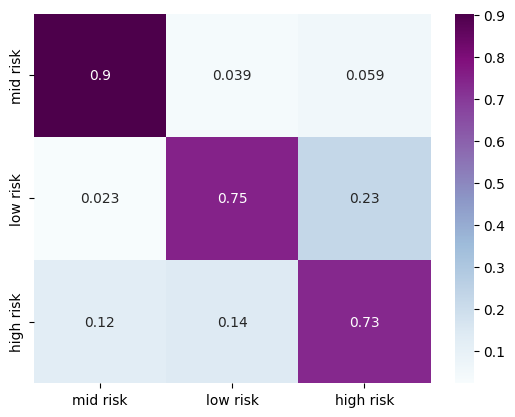

In [10]:
# visualize the confusion matrix using a heatmap
from sklearn.metrics import confusion_matrix

ypred = best_tree.predict(Xtest)

labels = ytest.unique()

cm_tree = confusion_matrix(ytest, ypred, normalize='true')
plt.figure()
sns.heatmap(cm_tree, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.show()

In [11]:
# classification report
from sklearn.metrics import classification_report

tree_report = classification_report(ytest, ypred)
print(tree_report)

              precision    recall  f1-score   support

   high risk       0.82      0.90      0.86        51
    low risk       0.86      0.75      0.80        88
    mid risk       0.67      0.73      0.70        64

    accuracy                           0.78       203
   macro avg       0.78      0.80      0.79       203
weighted avg       0.79      0.78      0.78       203



#### 2.randomforest

In [12]:
from sklearn.ensemble import RandomForestClassifier

# create a Random Forest Classifier
forest = RandomForestClassifier(random_state=122)

# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

# create the GridSearchCV object
grid_search_forest = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid_search_forest.fit(Xtrain, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_forest.best_params_)
print('Best Accuracy: ', grid_search_forest.best_score_)

# get the best model
best_forest = grid_search_forest.best_estimator_

Best Parameters:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Accuracy:  0.7990305233659016


In [13]:
# evaluate the best model on the test set
test_accuracy = best_forest.score(Xtest, ytest)
print('Test Accuracy: ', test_accuracy)

Test Accuracy:  0.8078817733990148


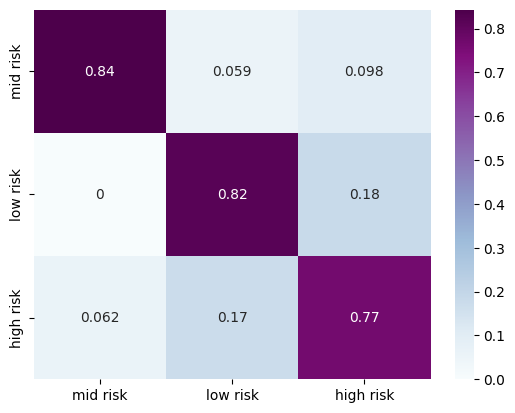

In [14]:
# visualize the confusion matrix using a heatmap
ypred = best_forest.predict(Xtest)

labels = ytest.unique()

cm_forest = confusion_matrix(ytest, ypred, normalize='true')
plt.figure()
sns.heatmap(cm_forest, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.show()

In [15]:
# classification report
forest_report = classification_report(ytest, ypred)
print(forest_report)

              precision    recall  f1-score   support

   high risk       0.91      0.84      0.88        51
    low risk       0.84      0.82      0.83        88
    mid risk       0.70      0.77      0.73        64

    accuracy                           0.81       203
   macro avg       0.82      0.81      0.81       203
weighted avg       0.81      0.81      0.81       203



#### 3. MultinomialNb

In [16]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
mNB = clf.fit(Xtrain,ytrain)
ypred = mNB.predict(Xtest)

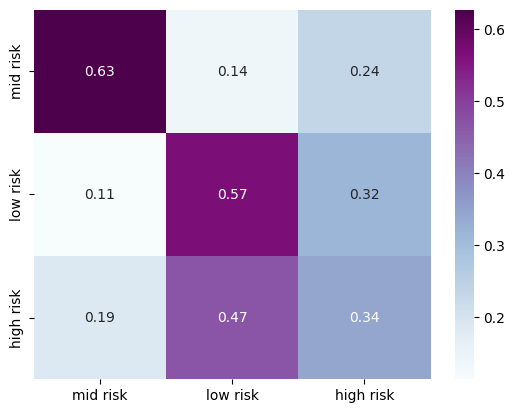

In [17]:
# visualize the confusion matrix using a heatmap
cm_mNB = confusion_matrix(ytest, ypred, normalize='true')
plt.figure()
sns.heatmap(cm_mNB, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.show()

In [18]:
# classification report
mNB_report = classification_report(ytest, ypred)
print(mNB_report)

              precision    recall  f1-score   support

   high risk       0.59      0.63      0.61        51
    low risk       0.57      0.57      0.57        88
    mid risk       0.35      0.34      0.35        64

    accuracy                           0.51       203
   macro avg       0.51      0.51      0.51       203
weighted avg       0.51      0.51      0.51       203



#### 4. Logistic Regression

In [19]:
# scale the feature matrix of train and test for logistic regression
from sklearn.preprocessing import MinMaxScaler

# create the MinMaxScaler object
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [20]:
from sklearn.linear_model import LogisticRegression

# create a logistic regression Classifier
logreg = LogisticRegression(random_state=122, max_iter=2000)

# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# create the GridSearchCV object
grid_search_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid_search_logreg.fit(Xtrain_scaled, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_logreg.best_params_)
print('Best Accuracy: ', grid_search_logreg.best_score_)

# get the best model
best_logreg = grid_search_logreg.best_estimator_

Best Parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy:  0.6263955161705674


In [21]:
# evaluate the best model on the test set
test_accuracy = best_logreg.score(Xtest_scaled, ytest)
print('Test Accuracy: ', test_accuracy)

Test Accuracy:  0.6600985221674877


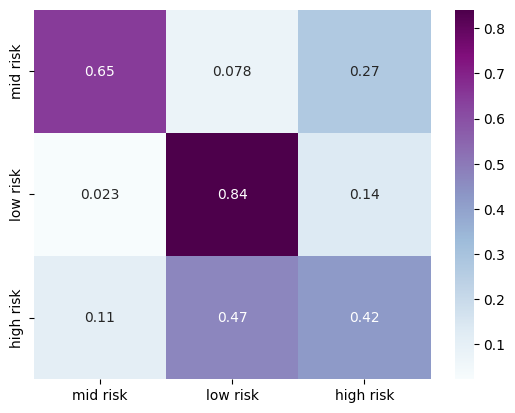

In [22]:
# visualize the confusion matrix using a heatmap
ypred = best_logreg.predict(Xtest_scaled)

labels = ytest.unique()

cm_logistic = confusion_matrix(ytest, ypred, normalize='true')
plt.figure()
sns.heatmap(cm_logistic, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.show()

In [23]:
# classification report
logistic_report = classification_report(ytest, ypred)
print(logistic_report)

              precision    recall  f1-score   support

   high risk       0.79      0.65      0.71        51
    low risk       0.69      0.84      0.76        88
    mid risk       0.51      0.42      0.46        64

    accuracy                           0.66       203
   macro avg       0.66      0.64      0.64       203
weighted avg       0.66      0.66      0.65       203



#### Comparing them

In [24]:
# define a helper function to perform model evaluation based on key metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_auc_score

def performance_evaluation(X,y,clf,classifier_name=''):
    ypred = clf.predict(X)
    accuracy = clf.score(X,y)
    precision, recall, fscore, support = precision_recall_fscore_support(y, ypred, average='weighted', zero_division=0)
    y_score = clf.predict_proba(X)
    ovr = roc_auc_score(y, y_score, multi_class='ovr', average='weighted')
    ovo = roc_auc_score(y, y_score, multi_class='ovo', average='weighted')
    metricName = ['Accuracy','Precision','Recall','F1_Score','AUC_OVR','AUC_OVO']
    metricValue = [accuracy,precision,recall,fscore,ovr,ovo]
    res = pd.DataFrame(metricValue, index=metricName, columns=[classifier_name])
    return res

In [25]:
# generate the performance summary for various models trained
tree_summary = performance_evaluation(Xtest,ytest,best_tree,'Decision Tree')
forest_summary = performance_evaluation(Xtest,ytest,best_forest,'Random Forest')
multinomialNB_summary = performance_evaluation(Xtest,ytest,mNB,'MultinomialNB')
logistic_summary = performance_evaluation(Xtest_scaled,ytest,best_logreg,'Logistic Regression')

# combine the summary of each model into a dataframe 
comparison_df = pd.concat([tree_summary,forest_summary,multinomialNB_summary,logistic_summary], axis=1)

# disply the summary dafaframe
display(comparison_df)

,Decision Tree,Random Forest,MultinomialNB,Logistic Regression
Accuracy,0.783251,0.807882,0.512315,0.660099
Precision,0.789620,0.813468,0.509885,0.655032
Recall,0.783251,0.807882,0.512315,0.660099
F1_Score,0.783970,0.809796,0.510939,0.651138
AUC_OVR,0.905911,0.935860,0.704376,0.795065
AUC_OVO,0.911288,0.939596,0.714758,0.802319


### confusion matrix for every modewl

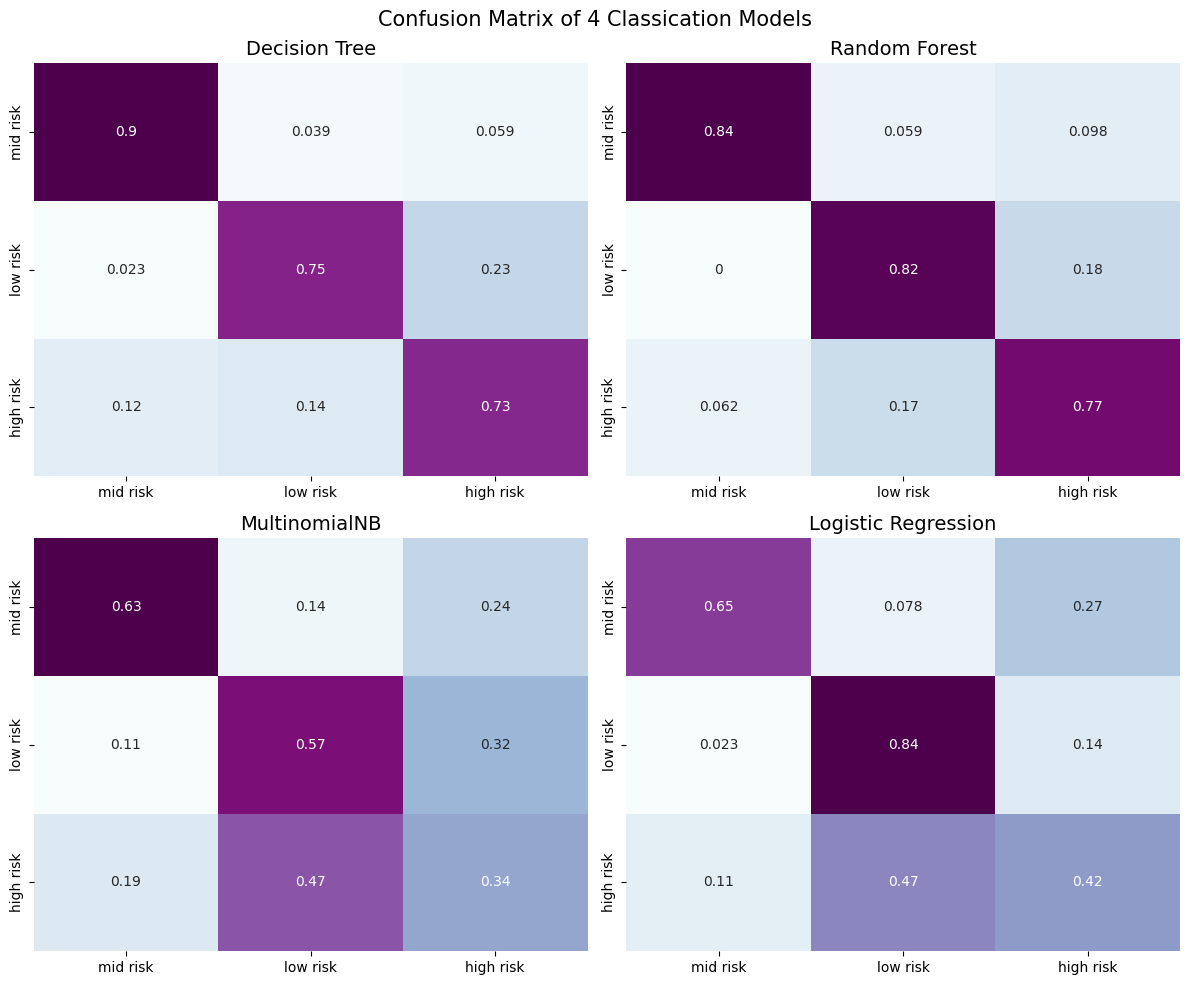

In [26]:
# confusion matrix for 4 classification models
figure, axes = plt.subplots(2,2, figsize=(12,10))
sns.heatmap(cm_tree, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[0,0])
axes[0,0].set_title('Decision Tree', fontsize=14)
sns.heatmap(cm_forest, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[0,1])
axes[0,1].set_title('Random Forest', fontsize=14)
sns.heatmap(cm_mNB, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1,0])
axes[1,0].set_title('MultinomialNB', fontsize=14)
sns.heatmap(cm_logistic, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1,1])
axes[1,1].set_title('Logistic Regression', fontsize=14)
figure.suptitle('Confusion Matrix of 4 Classication Models', fontsize=15)
plt.tight_layout()
plt.show()

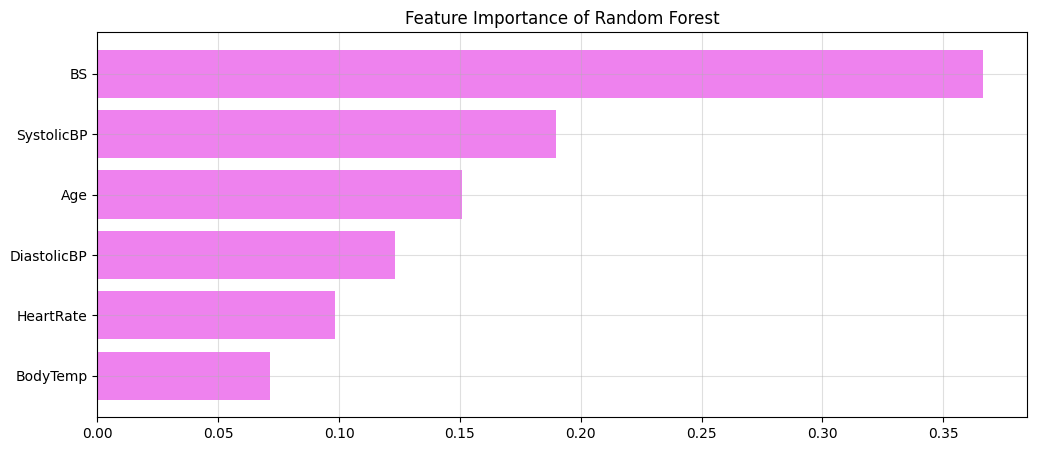

In [27]:
# feature imp of random forest
feature_importance = best_forest.feature_importances_

feature_score = pd.Series(feature_importance, index=Xtrain.columns)
score = feature_score.sort_values()

plt.figure(figsize=(12,5))
plt.barh(y=score.index, width=score.values, color='violet')
plt.grid(alpha=0.4)
plt.title('Feature Importance of Random Forest')
plt.show()

In [ ]:
import pickle

In [ ]:
pickle.dump(gbc_mod, open('finalmodel.sav', 'wb'))

# summary by us 
1. The Random Forest model showcases remarkable performance, outperforming other models with the highest accuracy, precision, and recall scores, signifying its superior predictive capabilities.
2. Noteworthy is the Random Forest model's proficiency in accurately classifying all three risk levels, as demonstrated by the comprehensive confusion matrix, providing robust insights into its classification accuracy.
3. Delving deeper into feature importance analysis, depicted in an extensive plot, blood glucose and systolic blood pressure emerge as the most influential features. These pivotal factors collectively contribute approximately 50% to the overall feature importance score, highlighting their significant impact on predictive outcomes.